In [1]:
from google.colab import drive
import os
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import os, torch, shutil, numpy as np
from glob import glob; from PIL import Image
from torch.utils.data import random_split, Dataset, DataLoader
from torchvision import transforms as T
torch.manual_seed(2023)

class CustomDataset(Dataset):

    def __init__(self, root, data, transformations = None):

        self.transformations, self.data = transformations, data
        self.im_paths = [im_path for im_path in sorted(glob(f"{root}/*/{data}/*.jpg"))]

        self.cls_names, self.cls_counts, count, data_count = {}, {}, 0, 0
        for idx, im_path in enumerate(self.im_paths):
            class_name = self.get_class(im_path)
            if class_name not in self.cls_names: self.cls_names[class_name] = count; self.cls_counts[class_name] = 1; count += 1
            else: self.cls_counts[class_name] += 1

    def get_class(self, path): return os.path.dirname(path).split("/")[-2]

    def __len__(self): return len(self.im_paths)

    def __getitem__(self, idx):

        im_path = self.im_paths[idx]
        im = Image.open(im_path).convert("RGB")
        gt = self.cls_names[self.get_class(im_path)]

        if self.transformations is not None: im = self.transformations(im)

        return im, gt

def get_dls(root, transformations, bs, ns = 4):

    ds = CustomDataset(root = root, data = "Train", transformations = transformations)
    ts_ds = CustomDataset(root = root, data = "Test", transformations = transformations)

    tr_len = int(len(ds) * 0.7); val_len = len(ds) - tr_len

    tr_ds, vl_ds = random_split(dataset = ds, lengths = [tr_len, val_len])

    tr_dl, val_dl, ts_dl = DataLoader(tr_ds, batch_size = bs, shuffle = True, num_workers = ns), DataLoader(vl_ds, batch_size = bs, shuffle = False, num_workers = ns), DataLoader(ts_ds, batch_size = 1, shuffle = False, num_workers = ns)

    return tr_dl, val_dl, ts_dl, ds.cls_names

root = "/content/drive/My Drive/Bone Break Classification"
mean, std, im_size = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225], 224
tfs = T.Compose([T.Resize((im_size, im_size)), T.ToTensor(), T.Normalize(mean = mean, std = std)])
tr_dl, val_dl, ts_dl, classes = get_dls(root = root, transformations = tfs, bs = 32)

print(len(tr_dl)); print(len(val_dl)); print(len(ts_dl)); print(classes)

22
10
140
{'Avulsion fracture': 0, 'Comminuted fracture': 1, 'Fracture Dislocation': 2, 'Greenstick fracture': 3, 'Hairline Fracture': 4, 'Impacted fracture': 5, 'Longitudinal fracture': 6, 'Oblique fracture': 7, 'Pathological fracture': 8, 'Spiral Fracture': 9}


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


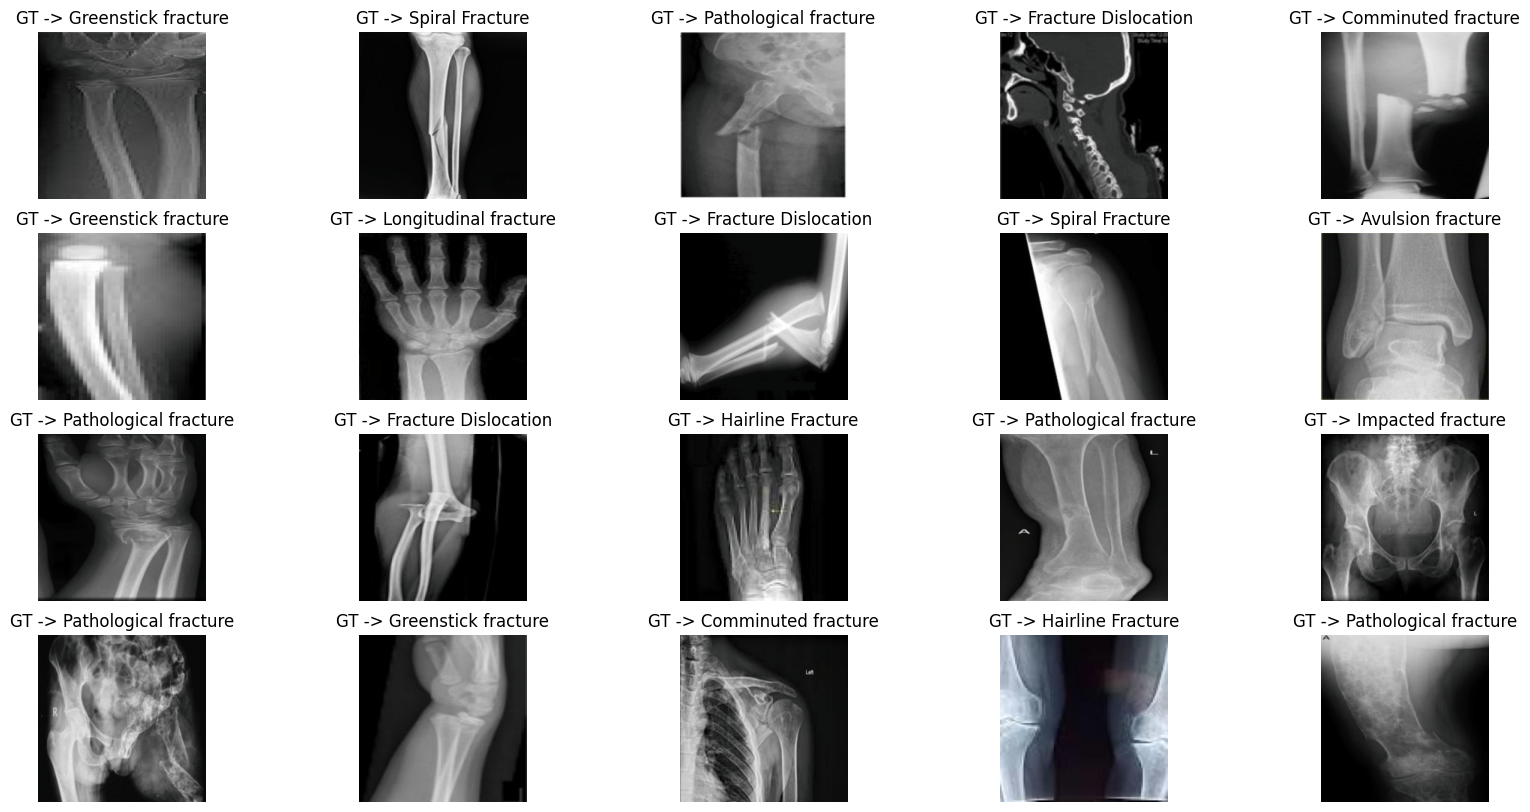

In [3]:
import random
from matplotlib import pyplot as plt

def tensor_2_im(t, t_type = "rgb"):

    gray_tfs = T.Compose([T.Normalize(mean = [ 0.], std = [1/0.5]), T.Normalize(mean = [-0.5], std = [1])])
    rgb_tfs = T.Compose([T.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]), T.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ])])

    invTrans = gray_tfs if t_type == "gray" else rgb_tfs

    return (invTrans(t) * 255).detach().squeeze().cpu().permute(1,2,0).numpy().astype(np.uint8) if t_type == "gray" else (invTrans(t) * 255).detach().cpu().permute(1,2,0).numpy().astype(np.uint8)

def visualize(data, n_ims, rows, cmap = None, cls_names = None):

    assert cmap in ["rgb", "gray"], "Rasmni oq-qora yoki rangli ekanini aniqlashtirib bering!"
    if cmap == "rgb": cmap = "viridis"

    plt.figure(figsize = (20, 10))
    indekslar = [random.randint(0, len(data) - 1) for _ in range(n_ims)]
    for idx, indeks in enumerate(indekslar):

        im, gt = data[indeks]
        # Start plot
        plt.subplot(rows, n_ims // rows, idx + 1)
        if cmap: plt.imshow(tensor_2_im(im, cmap), cmap=cmap)
        else: plt.imshow(tensor_2_im(im))
        plt.axis('off')
        if cls_names is not None: plt.title(f"GT -> {cls_names[int(gt)]}")
        else: plt.title(f"GT -> {gt}")

visualize(tr_dl.dataset, 20, 4, "rgb", list(classes.keys()))

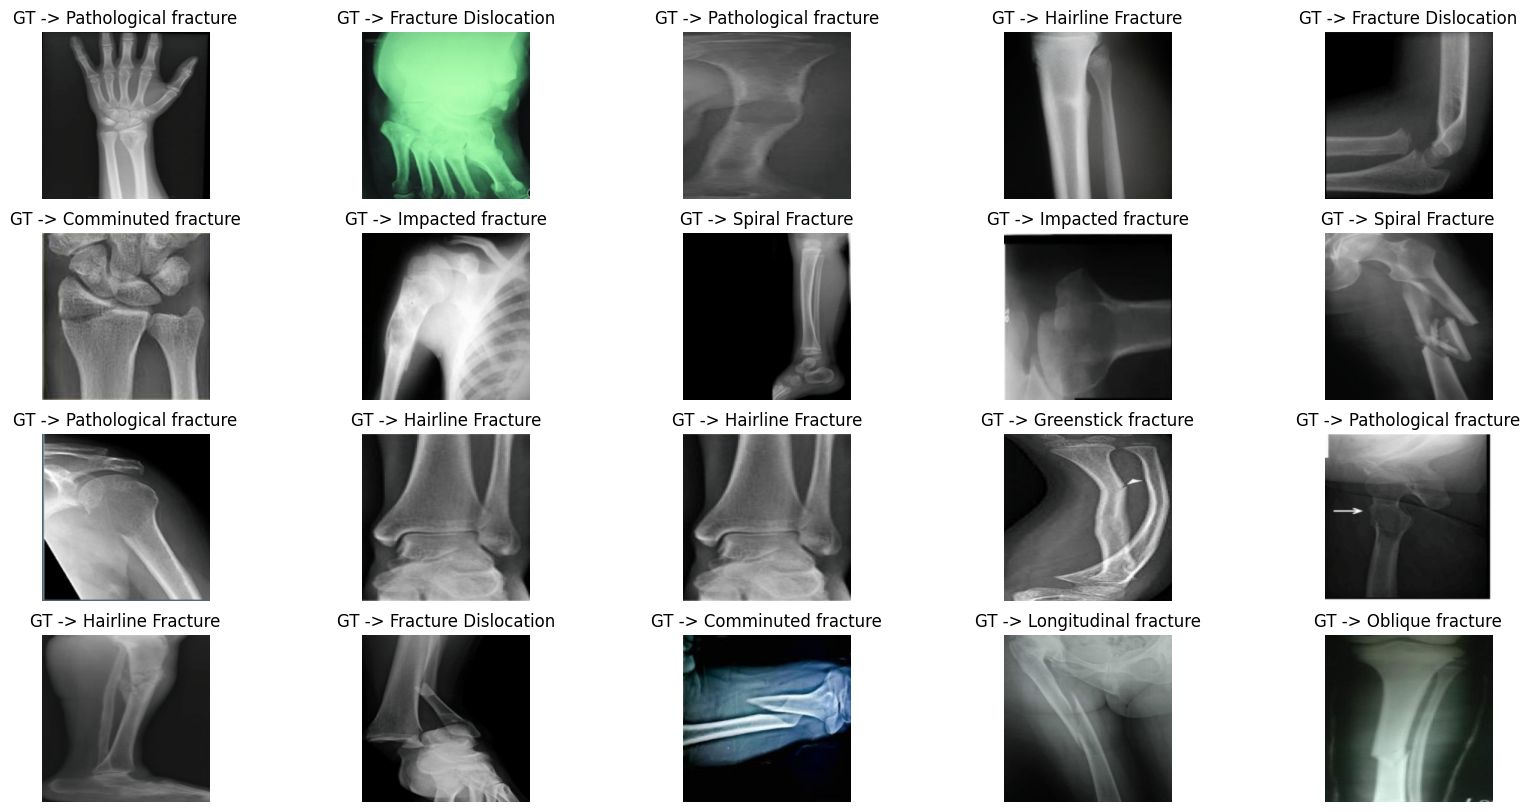

In [4]:
visualize(val_dl.dataset, 20, 4, "rgb", list(classes.keys()))

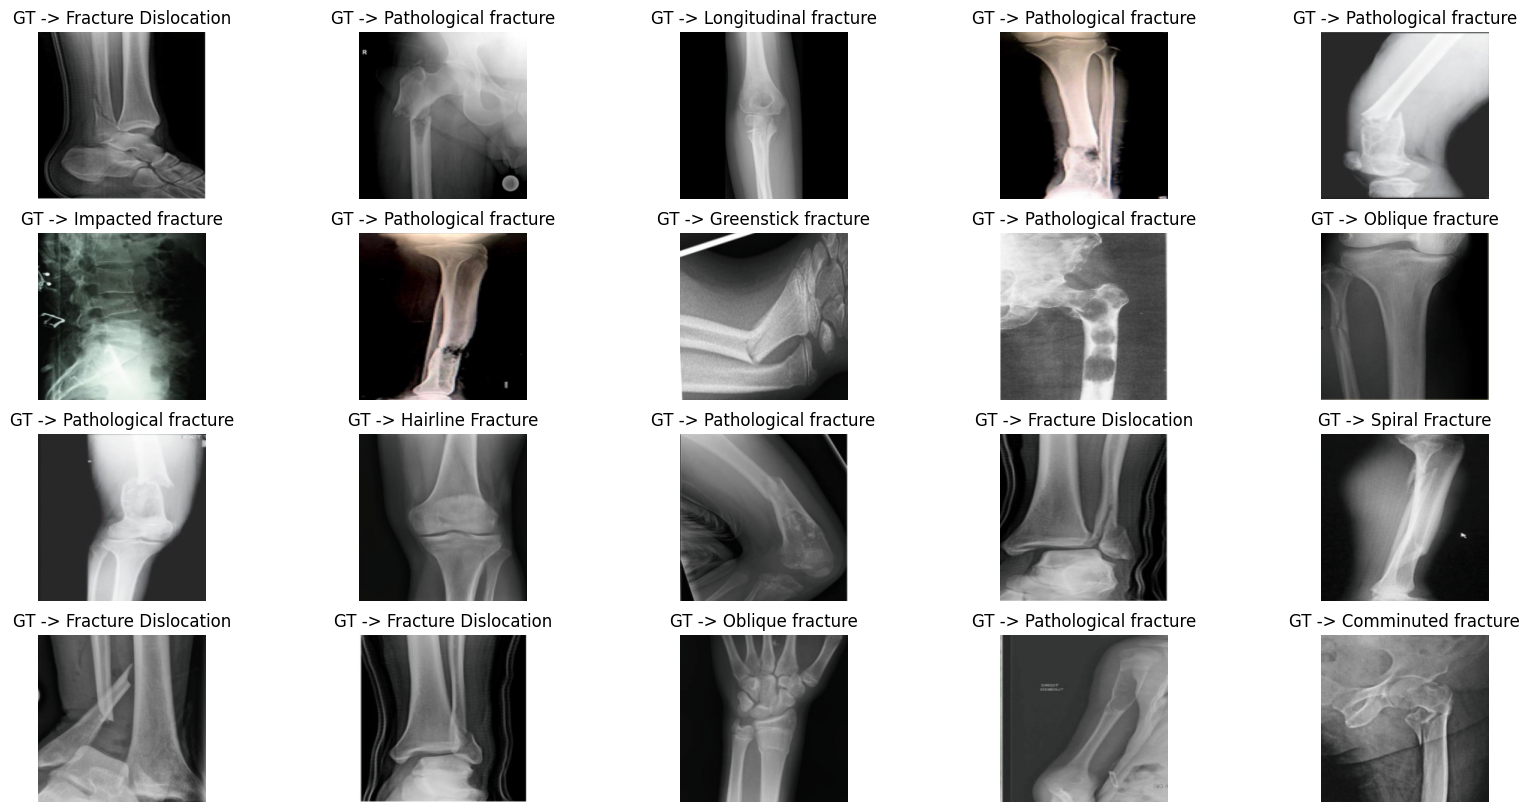

In [5]:
visualize(ts_dl.dataset, 20, 4, "rgb", list(classes.keys()))

<ipython-input-6-7d3c0ca04bb3>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(cls_names, rotation = 60)


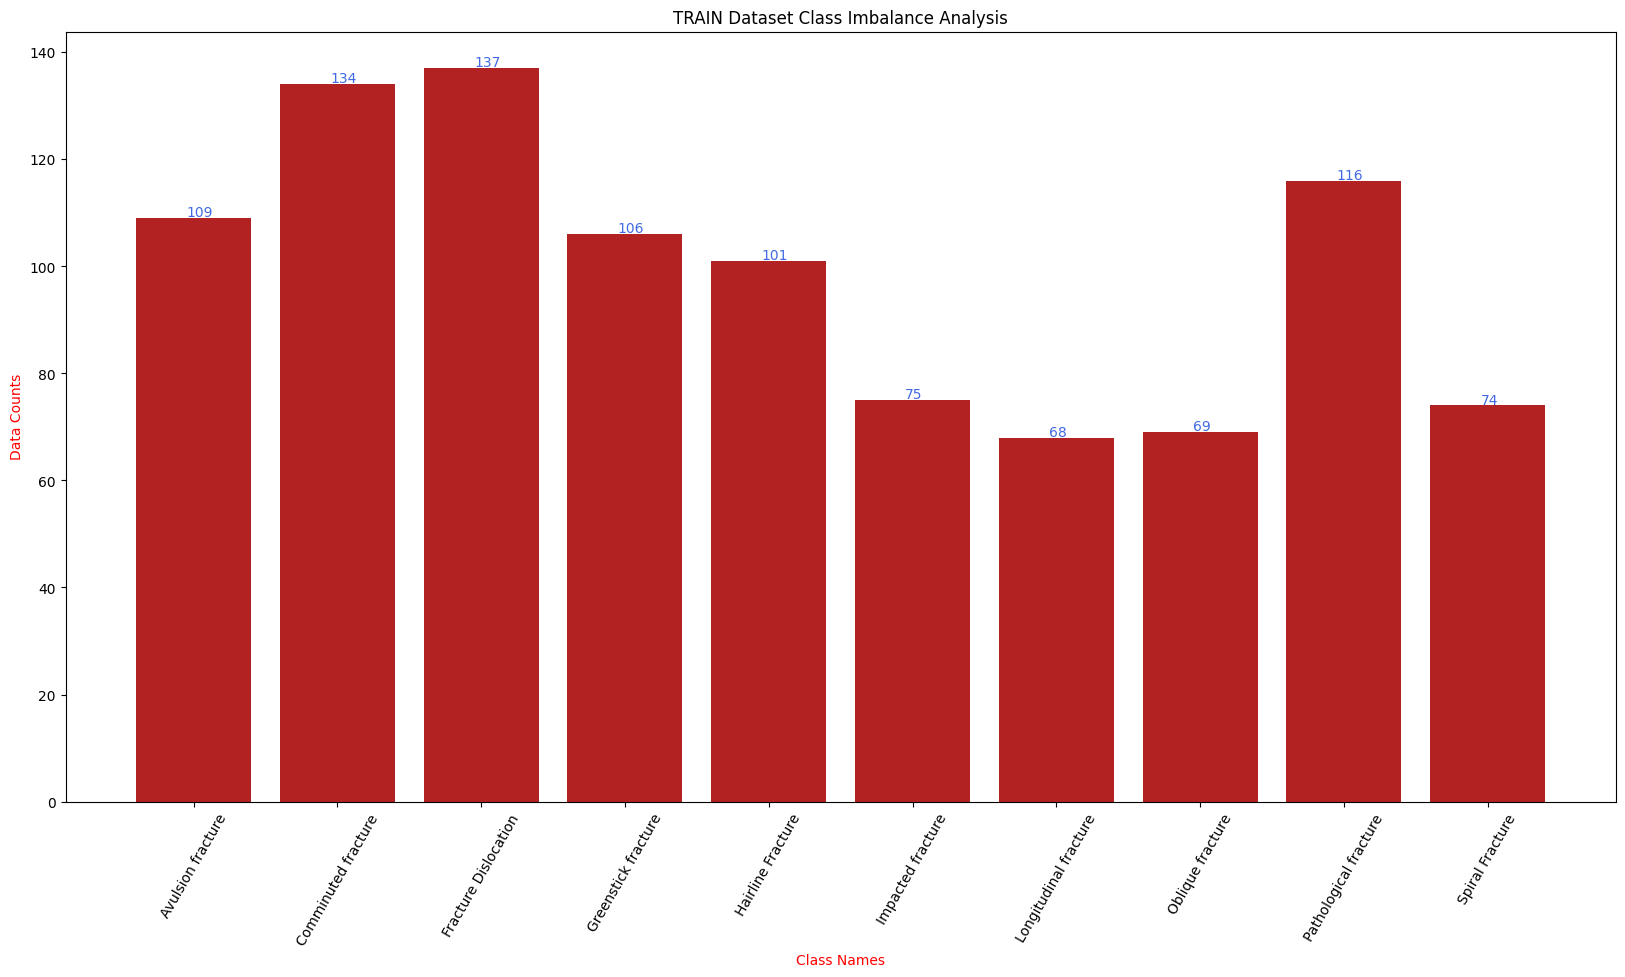

In [6]:
def data_analysis(root, transformations, data_type = "Train"):

    ds = CustomDataset(root = root, data = data_type, transformations = transformations)
    cls_counts, width, text_width = ds.cls_counts,  0.8, 0.05
    text_height = 4 if data_type == "train" else 0.3
    cls_names = list(cls_counts.keys()); counts = list(cls_counts.values())

    fig, ax = plt.subplots(figsize = (20, 10))
    indices = np.arange(len(counts))

    ax.bar(indices, counts, width, color = "firebrick")
    ax.set_xlabel("Class Names", color = "red")
    ax.set_xticklabels(cls_names, rotation = 60)
    ax.set(xticks = indices, xticklabels = cls_names)
    ax.set_ylabel("Data Counts", color = "red")
    ax.set_title(f"{data_type.upper()} Dataset Class Imbalance Analysis")

    for i, v in enumerate(counts): ax.text(i - text_width, v + text_height, str(v), color = "royalblue")

data_analysis(root = root, transformations = tfs)

<ipython-input-6-7d3c0ca04bb3>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(cls_names, rotation = 60)


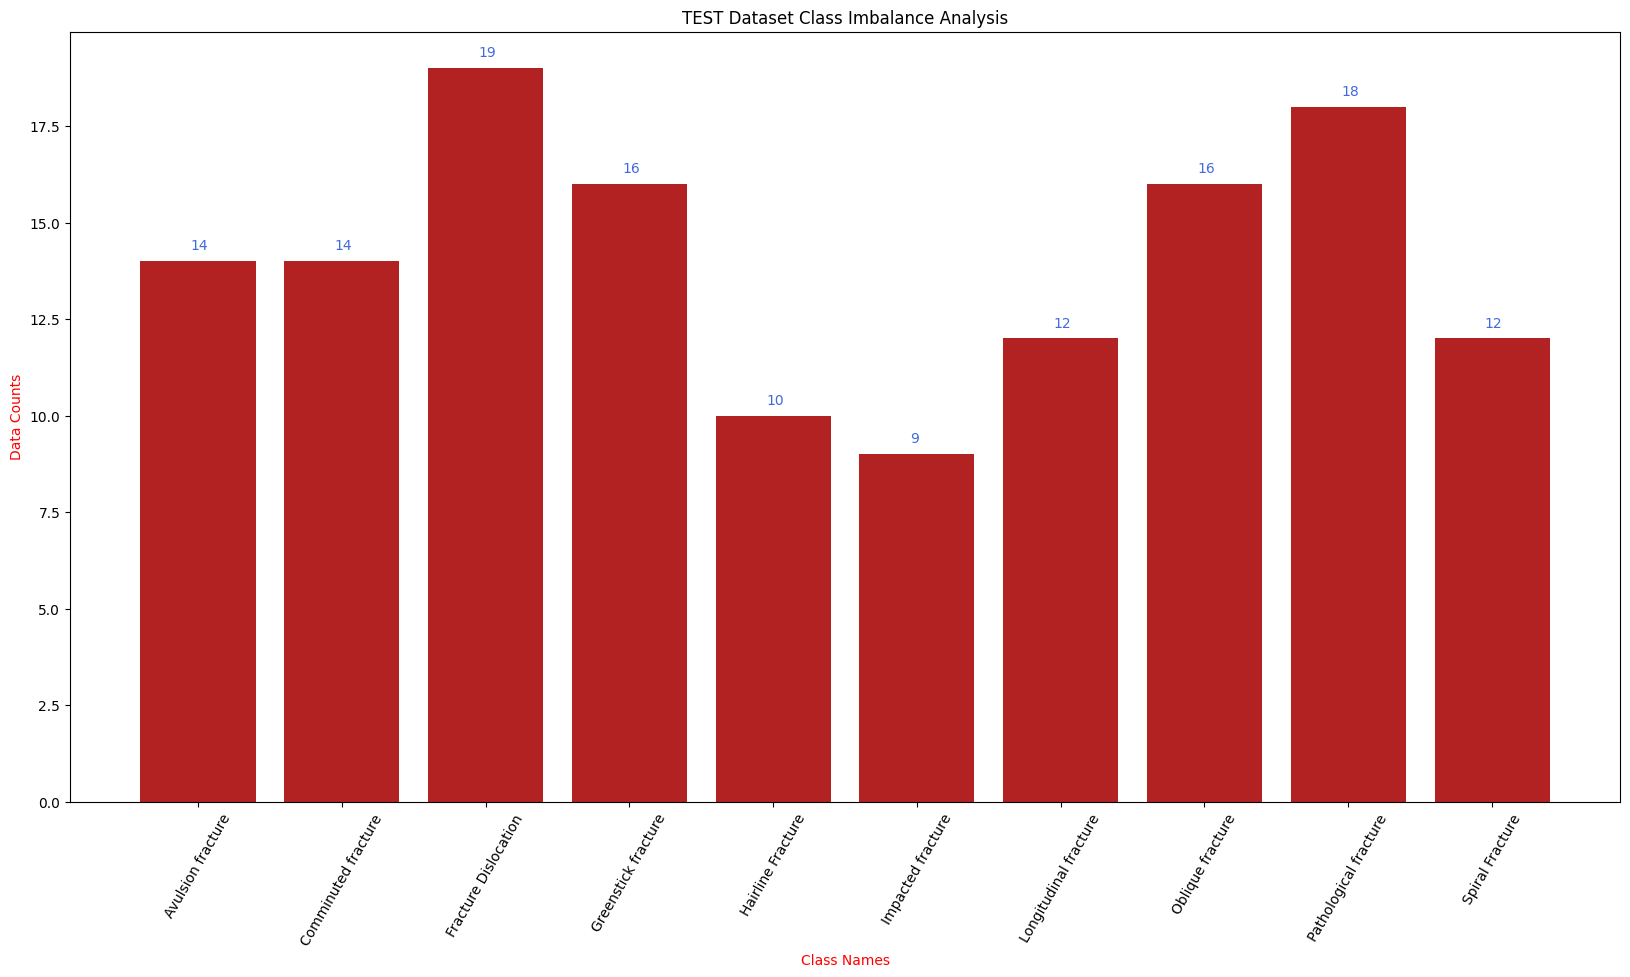

In [7]:
data_analysis(root = root, transformations = tfs, data_type = "Test")

In [8]:
!pip install timm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 12.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylin

In [11]:
import timm
from tqdm import tqdm
m = timm.create_model("rexnet_150", pretrained = True, num_classes = len(classes))
def train_setup(m): return m.to("cuda").eval(), 100, "cuda", torch.nn.CrossEntropyLoss(), torch.optim.Adam(params = m.parameters(), lr = 1e-4)
def to_device(batch, device): return batch[0].to(device), batch[1].to(device)
def get_metrics(model, ims, gts, loss_fn, epoch_loss, epoch_acc): preds = model(ims); loss = loss_fn(preds, gts); return loss, epoch_loss + (loss.item()), epoch_acc + (torch.argmax(preds, dim = 1) == gts).sum().item()

m, epochs, device, loss_fn, optimizer = train_setup(m)

save_prefix, save_dir = "bone", "saved_models"
print("Start training...")
best_acc, best_loss, threshold, not_improved, patience = 0, float("inf"), 0.01, 0, 10
tr_losses, val_losses, tr_accs, val_accs = [], [], [], []

best_loss = float(torch.inf)

for epoch in range(epochs):

    epoch_loss, epoch_acc = 0, 0
    for idx, batch in tqdm(enumerate(tr_dl)):

        ims, gts = to_device(batch, device)

        loss, epoch_loss, epoch_acc = get_metrics(m, ims, gts, loss_fn, epoch_loss, epoch_acc)
        optimizer.zero_grad(); loss.backward(); optimizer.step()

    tr_loss_to_track = epoch_loss / len(tr_dl)
    tr_acc_to_track  = epoch_acc / len(tr_dl.dataset)
    tr_losses.append(tr_loss_to_track); tr_accs.append(tr_acc_to_track)

    print(f"{epoch + 1}-epoch train process is completed!")
    print(f"{epoch + 1}-epoch train loss          -> {tr_loss_to_track:.3f}")
    print(f"{epoch + 1}-epoch train accuracy      -> {tr_acc_to_track:.3f}")

    m.eval()
    with torch.no_grad():
        val_epoch_loss, val_epoch_acc = 0, 0
        for idx, batch in enumerate(val_dl):
            ims, gts = batch
            ims, gts = ims.to(device), gts.to(device)

            preds = m(ims)
            loss = loss_fn(preds, gts)
            pred_cls = torch.argmax(preds.data, dim = 1)
            val_epoch_acc += (pred_cls == gts).sum().item()
            val_epoch_loss += loss.item()

        val_loss_to_track = val_epoch_loss / len(val_dl)
        val_acc_to_track  = val_epoch_acc / len(val_dl.dataset)
        val_losses.append(val_loss_to_track); val_accs.append(val_acc_to_track)

        print(f"{epoch + 1}-epoch validation process is completed!")
        print(f"{epoch + 1}-epoch validation loss     -> {val_loss_to_track:.3f}")
        print(f"{epoch + 1}-epoch validation accuracy -> {val_acc_to_track:.3f}")

        if val_loss_to_track < (best_loss + threshold):
            os.makedirs(save_dir, exist_ok = True)
            best_loss = val_loss_to_track
            torch.save(m.state_dict(), f"{save_dir}/{save_prefix}_best_model.pth")

        else:
            not_improved += 1
            print(f"Loss value did not decrease for {not_improved} epochs")
            if not_improved == patience:
                print(f"Stop training since loss value did not decrease for {patience} epochs.")
                break

Start training...


22it [00:07,  2.88it/s]

1-epoch train process is completed!
1-epoch train loss          -> 2.672
1-epoch train accuracy      -> 0.126


1-epoch validation process is completed!
1-epoch validation loss     -> 2.254
1-epoch validation accuracy -> 0.162


22it [00:05,  3.72it/s]

2-epoch train process is completed!
2-epoch train loss          -> 1.973
2-epoch train accuracy      -> 0.322


2-epoch validation process is completed!
2-epoch validation loss     -> 2.144
2-epoch validation accuracy -> 0.259


22it [00:05,  3.79it/s]

3-epoch train process is completed!
3-epoch train loss          -> 1.479
3-epoch train accuracy      -> 0.506


3-epoch validation process is completed!
3-epoch validation loss     -> 2.038
3-epoch validation accuracy -> 0.300


22it [00:07,  2.87it/s]

4-epoch train process is completed!
4-epoch train loss          -> 0.978
4-epoch train accuracy      -> 0.714


4-epoch validation process is completed!
4-epoch validation loss     -> 2.035
4-epoch validation accuracy -> 0.343


22it [00:06,  3.65it/s]

5-epoch train process is completed!
5-epoch train loss          -> 0.471
5-epoch train accuracy      -> 0.884


5-epoch validation process is completed!
5-epoch validation loss     -> 2.398
5-epoch validation accuracy -> 0.387
Loss value did not decrease for 1 epochs


22it [00:05,  3.78it/s]

6-epoch train process is completed!
6-epoch train loss          -> 0.225
6-epoch train accuracy      -> 0.948


6-epoch validation process is completed!
6-epoch validation loss     -> 2.355
6-epoch validation accuracy -> 0.364
Loss value did not decrease for 2 epochs


22it [00:07,  2.78it/s]

7-epoch train process is completed!
7-epoch train loss          -> 0.123
7-epoch train accuracy      -> 0.974


7-epoch validation process is completed!
7-epoch validation loss     -> 2.296
7-epoch validation accuracy -> 0.411
Loss value did not decrease for 3 epochs


22it [00:05,  3.74it/s]

8-epoch train process is completed!
8-epoch train loss          -> 0.061
8-epoch train accuracy      -> 0.991


8-epoch validation process is completed!
8-epoch validation loss     -> 2.531
8-epoch validation accuracy -> 0.394
Loss value did not decrease for 4 epochs


22it [00:05,  3.68it/s]

9-epoch train process is completed!
9-epoch train loss          -> 0.039
9-epoch train accuracy      -> 0.997


9-epoch validation process is completed!
9-epoch validation loss     -> 2.466
9-epoch validation accuracy -> 0.451
Loss value did not decrease for 5 epochs


22it [00:07,  3.07it/s]

10-epoch train process is completed!
10-epoch train loss          -> 0.039
10-epoch train accuracy      -> 0.994


10-epoch validation process is completed!
10-epoch validation loss     -> 2.529
10-epoch validation accuracy -> 0.431
Loss value did not decrease for 6 epochs


22it [00:05,  3.77it/s]

11-epoch train process is completed!
11-epoch train loss          -> 0.009
11-epoch train accuracy      -> 0.999


11-epoch validation process is completed!
11-epoch validation loss     -> 2.596
11-epoch validation accuracy -> 0.421
Loss value did not decrease for 7 epochs


22it [00:05,  3.68it/s]

12-epoch train process is completed!
12-epoch train loss          -> 0.008
12-epoch train accuracy      -> 0.997


12-epoch validation process is completed!
12-epoch validation loss     -> 2.737
12-epoch validation accuracy -> 0.424
Loss value did not decrease for 8 epochs


22it [00:07,  3.13it/s]

13-epoch train process is completed!
13-epoch train loss          -> 0.017
13-epoch train accuracy      -> 0.996


13-epoch validation process is completed!
13-epoch validation loss     -> 2.713
13-epoch validation accuracy -> 0.424
Loss value did not decrease for 9 epochs


22it [00:05,  3.68it/s]

14-epoch train process is completed!
14-epoch train loss          -> 0.010
14-epoch train accuracy      -> 0.997


14-epoch validation process is completed!
14-epoch validation loss     -> 2.779
14-epoch validation accuracy -> 0.434
Loss value did not decrease for 10 epochs
Stop training since loss value did not decrease for 10 epochs.


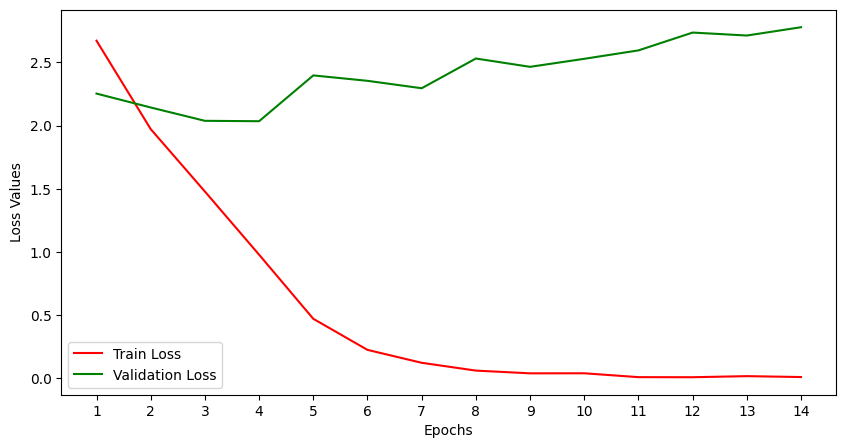

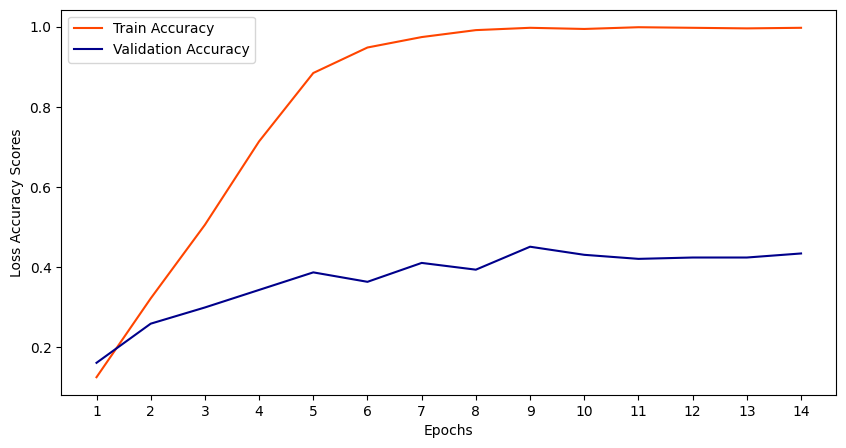

In [12]:
def learning_curves(tr_losses, val_losses, tr_accs, val_accs):

    plt.figure(figsize = (10, 5))
    plt.plot(tr_losses, label = "Train Loss", c = "red")
    plt.plot(val_losses, label = "Validation Loss", c = "green")
    plt.xlabel("Epochs"); plt.ylabel("Loss Values")
    plt.xticks(ticks = np.arange(len(tr_losses)), labels = [i for i in range(1, len(tr_losses) + 1)])
    plt.legend(); plt.show()

    plt.figure(figsize = (10, 5))
    plt.plot(tr_accs, label = "Train Accuracy", c = "orangered")
    plt.plot(val_accs, label = "Validation Accuracy", c = "darkblue")
    plt.xlabel("Epochs"); plt.ylabel("Loss Accuracy Scores")
    plt.xticks(ticks = np.arange(len(tr_accs)), labels = [i for i in range(1, len(tr_accs) + 1)])
    plt.legend(); plt.show()

learning_curves(tr_losses, val_losses, tr_accs, val_accs)

140it [00:08, 16.28it/s]


Accuracy of the model on the test data -> 0.321


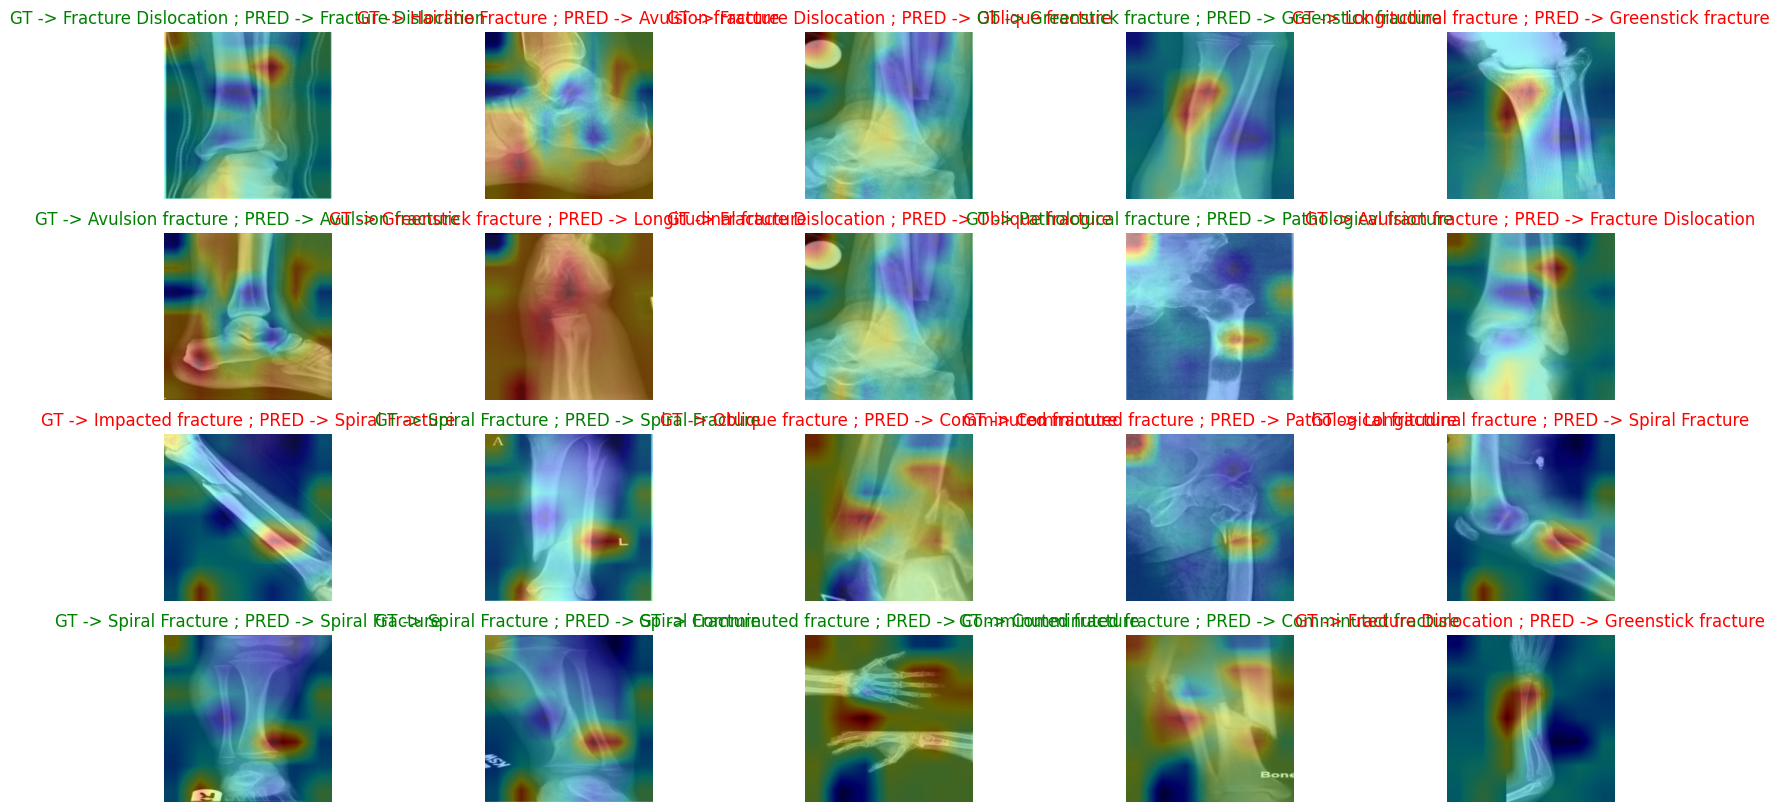

In [13]:
import cv2
class SaveFeatures():

    """ Extract pretrained activations"""
    features = None
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.features = ((output.cpu()).data).numpy()
    def remove(self): self.hook.remove()

def getCAM(conv_fs, linear_weights, class_idx):

    bs, chs, h, w = conv_fs.shape
    cam = linear_weights[class_idx].dot(conv_fs[0,:, :, ].reshape((chs, h * w)))
    cam = cam.reshape(h, w)

    return (cam - np.min(cam)) / np.max(cam)

def inference(model, device, test_dl, num_ims, row, final_conv, fc_params, cls_names = None):

    weight, acc = np.squeeze(fc_params[0].cpu().data.numpy()), 0
    activated_features = SaveFeatures(final_conv)
    preds, images, lbls = [], [], []
    for idx, batch in tqdm(enumerate(test_dl)):
        im, gt = to_device(batch, device)
        pred_class = torch.argmax(model(im), dim = 1)
        acc += (pred_class == gt).sum().item()
        images.append(im)
        preds.append(pred_class.item())
        lbls.append(gt.item())

    print(f"Accuracy of the model on the test data -> {(acc / len(test_dl.dataset)):.3f}")

    plt.figure(figsize = (20, 10))
    indekslar = [random.randint(0, len(images) - 1) for _ in range(num_ims)]

    for idx, indeks in enumerate(indekslar):

        im = images[indeks].squeeze()
        pred_idx = preds[indeks]
        heatmap = getCAM(activated_features.features, weight, pred_idx)

        # Start plot
        plt.subplot(row, num_ims // row, idx + 1)
        plt.imshow(tensor_2_im(im), cmap = "gray"); plt.axis("off")
        plt.imshow(cv2.resize(heatmap, (im_size, im_size), interpolation=cv2.INTER_LINEAR), alpha=0.4, cmap='jet'); plt.axis("off")

        if cls_names is not None: plt.title(f"GT -> {cls_names[int(lbls[indeks])]} ; PRED -> {cls_names[int(preds[indeks])]}", color=("green" if {cls_names[int(lbls[indeks])]} == {cls_names[int(preds[indeks])]} else "red"))
        else: plt.title(f"GT -> {gt} ; PRED -> {pred}")

m.load_state_dict(torch.load(f"{save_dir}/{save_prefix}_best_model.pth"))
m.eval()
final_conv, fc_params = m.features[-1], list(m.head.fc.parameters())
inference(model = m.to(device), device = device, test_dl = ts_dl, num_ims = 20, row = 4, cls_names = list(classes.keys()), final_conv = final_conv, fc_params = fc_params)